# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

- **Team Name:** ThreeTwoOneSix
- **Team Members:** Nhung Le (nhl256), Yipeng Lai (yl6038), Shirley Xu (xx852), B V Nithish Addepalli (bva212)

In [1]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict

## I. N-Gram Language Modeling

#### Utilities

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [3]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [5]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [5]:
class NGramInterpolation(object):
    def __init__(self, n, lambdas, vsize):
        self.n = n
        self.lambdas = lambdas
        self.vsize = vsize
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
    
    def estimate(self, sequences):
        for n in range(1, self.n+1):
            for sequence in sequences:
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence)-n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
    
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_interp_prob(ngram))
        return total_logp
    
    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = (self.count[prefix][word] / max(self.total[prefix], 1))
        return prob
    
    def ngram_interp_prob(self, sequence):
        ngrams = []
        for i in range(len(sequence)):
            ngrams.append(sequence[i:])
        probs = [self.ngram_prob(ngram) for ngram in ngrams]
        probs.append(1.0/self.vsize)
        interp_prob = sum([lambda_ * prob for lambda_, prob in zip(self.lambdas, probs)])
        return interp_prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [6]:
datasets, vocab = load_wikitext()

Vocab size: 33175


**n = 2**: $\lambda_2$ = 0.5, $\lambda_1$ = 0.4, $\lambda_0$ = 0.1

In [8]:
n = 2
# in the order of lambda2, lambda1, lambda0
lambdas = [0.5, 0.4, 0.1]
lm = NGramInterpolation(n=n, lambdas=lambdas, vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])
print("Interpolation, n=%d, Train Perplexity: %.3f" % (n, perplexity(lm, datasets['train'])))
print("Interpolation, n=%d, Valid Perplexity: %.3f" % (n, perplexity(lm, datasets['valid'])))

Interpolation, n=2, Train Perplexity: 127.724
Interpolation, n=2, Valid Perplexity: 320.489


**n=3**: $\lambda_3$ = 0.1, $\lambda_2$ = 0.5, $\lambda_1$ = 0.3, $\lambda_0$ = 0.1

In [9]:
n = 3
# in the order of lambda3, lambda2, lambda1, lambda0
lambdas = [0.1, 0.5, 0.3, 0.1]
lm = NGramInterpolation(n=n, lambdas=lambdas, vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])
print("Interpolation, n=%d, Train Perplexity: %.3f" % (n, perplexity(lm, datasets['train'])))
print("Interpolation, n=%d, Valid Perplexity: %.3f" % (n, perplexity(lm, datasets['valid'])))

Interpolation, n=3, Train Perplexity: 33.746
Interpolation, n=3, Valid Perplexity: 283.795


**n=4**: $\lambda_4$ = 0.01, $\lambda_3$ = 0.03, $\lambda_2$ = 0.65, $\lambda_1$ = 0.25, $\lambda_0$ = 0.06

In [10]:
n = 4
# in the order of lambda4, lambda3, lambda2, lambda1, lambda0
lambdas = [0.01, 0.03, 0.65, 0.25, 0.06]
lm = NGramInterpolation(n=n, lambdas=lambdas, vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])
print("Interpolation, n=%d, Train Perplexity: %.3f" % (n, perplexity(lm, datasets['train'])))
print("Interpolation, n=%d, Valid Perplexity: %.3f" % (n, perplexity(lm, datasets['valid'])))

Interpolation, n=4, Train Perplexity: 30.419
Interpolation, n=4, Valid Perplexity: 283.463


#### Interpretation:

After carefully choosing $\lambda$ values for each n-gram interpolation model, we found that all three interpolation models outperform the additive smoothing model and performance (measured by validation perplexity) improves as n increases.

## II. Neural Language Modeling with a Recurrent Neural Network

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

In [2]:
import os
import json
import sys

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines
  
try:
    from tqdm import tqdm #prgress bar
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm
from collections import defaultdict

Installing the package, RESTART THIS CELL


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [ ]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
        # eg:
        # a = 'bos hello world! eos'.split()
        # a = ['bos', 'hello', 'world', '!', 'eos']
        # a[1:] = 
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [ ]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [ ]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #begin of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>') #padding
        self.add_token('<unk>') #need unknown because the word you see in your sentence (of text) is not in your current vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l): # WHY IS IT A PROBLEM?
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l] #if this word exists in ur vocab, return the id of that word
                                                                                # if not then return id of unk
    
    def __len__(self):
        return len(self.tokens)

In [ ]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    '''
    datasets : dictionary {train: [], val: [], test: []}
    dictionary:
    ngram_order: len of each ngrams
    '''
    tokenized_datasets = {}
    for split, dataset in datasets.items():
      # datasets: a list of sentences
        _current_dictified = []
        for l in tqdm(dataset): #l sentence
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets #dictionary

In [ ]:
def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=5):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

In [ ]:
def trainValidModel(model, num_epochs, load_pretrained, loaders): 
    val_losses = []
    train_losses = []
    best_val_loss = np.inf
    best_model_state_dict = model.state_dict()

    for epoch_number in range(num_epochs):
        avg_loss=0
        if not load_pretrained:
            # do train
            model.train()
            train_log_cache = []
            train_loss = []
            
            for i, (inp, target) in enumerate(loaders['train']):
                optimizer.zero_grad()
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

                loss.backward()
                optimizer.step()

                train_log_cache.append(loss.item())
                train_loss.append(loss.item())
                

                if i % 500 == 0:
                    avg_loss = sum(train_log_cache)/len(train_log_cache)
                    print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                    train_log_cache = []
                    
        train_losses.append(sum(train_loss) / len(train_loss)) 

        #do valid
        valid_perplextity = []
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())

            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
            
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state_dict = model.state_dict()

        val_losses.append(avg_val_loss)

        if load_pretrained:
            break

    return train_losses, val_losses, best_val_loss, best_model_state_dict

In [ ]:
def ppl_plot(val_loss_list, train_loss_list, model_name):
    train_ppl = [2**(train_loss) / np.log(2) for train_loss in train_loss_list]
    val_ppl = [2**(val_loss) / np.log(2) for val_loss in val_loss_list]
    epoch = [i for i in range(10)]
    
    plt.plot(epoch, train_ppl, label='Train Perplexity')
    plt.plot(epoch, val_ppl, label='Val Perplexity')
    
    plt.legend()
    plt.title('Perplexity Curve for {}'.format(model_name))
    plt.show()
    

### Data Proprocessing

In [15]:
wiki_datasets, wiki_vocab = load_wikitext(filename='wikitext2-sentencized.json')

Vocab size: 33175


In [16]:
wiki_dict = Dictionary(wiki_datasets, include_valid=True)

100%|██████████| 8464/8464 [00:11<00:00, 762.94it/s]


In [17]:
wiki_tokenized_datasets = tokenize_dataset(wiki_datasets, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 126349.59it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [18]:
# debug
len(wiki_tensor_dataset['train'])

78274

In [ ]:
embedding_size = 64
hidden_size = 128
num_layers = 2
rnn_dropout = 0.1
batch_size = 32
lr = 0.001
optimizer = optim.Adam

In [ ]:
wiki_loaders = {}

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

## 2.1.1. Baseline Models

### 2.1.1.1 Baseline Model - Lab's vanilla RNN

In [ ]:
class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        #optioins: a dictionary with key = argument, value = value of that argument
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], 
                                   embedding_dim=options['embedding_dim'], 
                                   padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence) #rnn gives u all outputs / hidden as it has so far.
        rnn_outputs = self.rnn(embeddings) #
        logits = self.projection(rnn_outputs[0]) #rnn_outpus[0] = size of vocab, as we want to predict this specific word given the chain of words
        
        return logits

In [ ]:
# creating a model, criterion and optimizer
load_pretrained = False
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:

    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    

    rnn_model = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# When we may want to think about the sum loss
#criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')

model_parameters = [p for p in rnn_model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=lr)

In [23]:
rnn_model

RNNLanguageModel(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)

In [24]:
rnn_train_losses, rnn_val_losses, rnn_best_val_loss, rnn_best_model_state_dict = trainValidModel(rnn_model, num_epochs=10, load_pretrained=False, loaders=wiki_loaders)

Step 0 avg train loss = 10.4342
Step 500 avg train loss = 6.9247
Step 1000 avg train loss = 6.3302
Step 1500 avg train loss = 6.1014
Step 2000 avg train loss = 5.9742
Validation loss after 0 epoch = 5.7105
Step 0 avg train loss = 5.5408
Step 500 avg train loss = 5.7178
Step 1000 avg train loss = 5.6793
Step 1500 avg train loss = 5.6428
Step 2000 avg train loss = 5.6093
Validation loss after 1 epoch = 5.5000
Step 0 avg train loss = 5.5913
Step 500 avg train loss = 5.4150
Step 1000 avg train loss = 5.4153
Step 1500 avg train loss = 5.4008
Step 2000 avg train loss = 5.3984
Validation loss after 2 epoch = 5.4277
Step 0 avg train loss = 5.2298
Step 500 avg train loss = 5.2281
Step 1000 avg train loss = 5.2424
Step 1500 avg train loss = 5.2466
Step 2000 avg train loss = 5.2414
Validation loss after 3 epoch = 5.3838
Step 0 avg train loss = 4.9245
Step 500 avg train loss = 5.0856
Step 1000 avg train loss = 5.1098
Step 1500 avg train loss = 5.1289
Step 2000 avg train loss = 5.1331
Validation lo

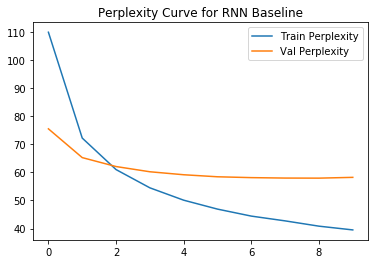

In [43]:
ppl_plot(rnn_val_losses, rnn_train_losses, 'RNN Baseline')

In [29]:
torch.save(rnn_best_model_state_dict, 'rnn_baseline.pth')
print('rnn_train_losses', rnn_train_losses)
torch.save(rnn_train_losses, 'rnn_train_losses.pth')
print('rnn_val_losses', rnn_val_losses)
torch.save(rnn_val_losses, 'rnn_val_losses.pth')
print('rnn_best_val_losses', rnn_best_val_loss)

rnn_train_losses [6.252407784066397, 5.646171327410886, 5.40232812798067, 5.23965046363896, 5.118026930797718, 5.023302161844594, 4.944591891877643, 4.88822966494948, 4.823098996049002, 4.775098534472193]
rnn_val_losses [5.7104843409556265, 5.499961052300795, 5.427714178697118, 5.383811409068557, 5.358119032517919, 5.340339171211674, 5.332865657446519, 5.3289685015408494, 5.32826722343013, 5.3352876663208]
rnn_best_val_losses 5.32826722343013


In [ ]:
!ls

rnn_baseline.pth  rnn_train_losses.pth	rnn_val_losses.pth


### 2.1.1.2. LSTM Language Model

In [ ]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, lstm and projection layer into a single model
    """
    def __init__(self, options):
        #optioins: a dictionary with key = argument, value = value of that argument
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], 
                                   embedding_dim=options['embedding_dim'], 
                                   padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'],
                            options['hidden_size'],
                            options['num_layers'],
                            dropout=options['rnn_dropout'],
                            batch_first=True)
        self.projection = nn.Linear(options['hidden_size'],
                                    options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence) #rnn gives u all outputs / hidden as it has so far.
        lstm_outputs = self.lstm(embeddings) #
        logits = self.projection(lstm_outputs[0]) #lstm_outpus[0] = size of vocab, as we want to predict this specific word given the chain of words
        
        return logits

In [ ]:
# creating a model, criterion and optimizer
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:

    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    # CHANGE THE MODEL HERE
    lstm_model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# CHANGE THE MODEL HERE
model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=lr)

In [33]:
lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel(lstm_model, num_epochs=10, load_pretrained=False, loaders=wiki_loaders)

Step 0 avg train loss = 10.4114
Step 500 avg train loss = 7.2020
Step 1000 avg train loss = 6.6110
Step 1500 avg train loss = 6.3561
Step 2000 avg train loss = 6.1966
Validation loss after 0 epoch = 5.8480
Step 0 avg train loss = 5.9845
Step 500 avg train loss = 5.9094
Step 1000 avg train loss = 5.8370
Step 1500 avg train loss = 5.7905
Step 2000 avg train loss = 5.7301
Validation loss after 1 epoch = 5.5575
Step 0 avg train loss = 5.7918
Step 500 avg train loss = 5.5433
Step 1000 avg train loss = 5.5357
Step 1500 avg train loss = 5.4955
Step 2000 avg train loss = 5.4782
Validation loss after 2 epoch = 5.4235
Step 0 avg train loss = 5.4046
Step 500 avg train loss = 5.3223
Step 1000 avg train loss = 5.3106
Step 1500 avg train loss = 5.2968
Step 2000 avg train loss = 5.2941
Validation loss after 3 epoch = 5.3422
Step 0 avg train loss = 5.1980
Step 500 avg train loss = 5.1636
Step 1000 avg train loss = 5.1450
Step 1500 avg train loss = 5.1484
Step 2000 avg train loss = 5.1360
Validation lo

In [34]:
torch.save(lstm_best_model_state_dict, 'lstm_baseline.pth')
print('lstm_train_losses', lstm_train_losses)
torch.save(lstm_train_losses, 'lstm_baseline_train_losses.pth')
print('lstm_val_losses', lstm_val_losses)
torch.save(lstm_val_losses, 'lstm_baseline_val_losses.pth')
print('lstm_best_val_losses', lstm_best_val_loss)

lstm_train_losses [6.4959824433071445, 5.792999350396185, 5.501964436777767, 5.30020079984926, 5.143156447993233, 5.017436327035933, 4.914898755261008, 4.827856869808644, 4.7535781523233345, 4.687967846624502]
lstm_val_losses [5.847984168214618, 5.557509949522198, 5.423473055857532, 5.342226663625465, 5.3021189527691535, 5.27891776066906, 5.273949594317742, 5.279240471462034, 5.290816416830387, 5.295930122879316]
lstm_best_val_losses 5.273949594317742


In [ ]:
lstm_baseline_train_losses = torch.load('lstm_baseline_train_losses.pth')
lstm_baseline_val_losses = torch.load('lstm_baseline_val_losses.pth')

### 2.1.1.3. Results (LSTM vs. Baseline)



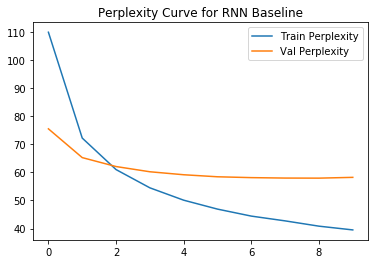

In [50]:
ppl_plot(rnn_val_losses, rnn_train_losses, 'RNN Baseline')

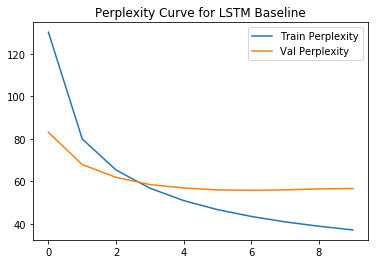

In [51]:
ppl_plot(lstm_baseline_val_losses, lstm_baseline_train_losses, 'LSTM Baseline')

As shown in the two graphs above, LSTM baseline does relatively better than the baseline RNN model, as the LSTM baseline model has lower perplexity score.

## 2.1.2 Performance Variation Based on Hyperparameter Values




### 2.1.2.1 Tune on Embedding Size




In [ ]:
embedding_size = 128
hidden_size = 64
num_layers = 2
rnn_dropout = 0.1
batch_size = 32
optimizer = optim.Adam

In [ ]:
wiki_loaders = {}

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn) 

In [ ]:
def trainValidModel_noTrainLossPrint(model, num_epochs, load_pretrained, loaders): 
    val_losses = []
    train_losses = []
    best_val_loss = np.inf
    best_model_state_dict = model.state_dict()

    for epoch_number in range(num_epochs):
        avg_loss=0
        if not load_pretrained:
            # do train
            model.train()
            train_log_cache = []
            train_loss = []
            
            for i, (inp, target) in enumerate(loaders['train']):
                optimizer.zero_grad()
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

                loss.backward()
                optimizer.step()

                train_log_cache.append(loss.item())
                train_loss.append(loss.item())
                

                if i % 500 == 0:
                    avg_loss = sum(train_log_cache)/len(train_log_cache)
                    #print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                    train_log_cache = []
                    
        train_losses.append(sum(train_loss) / len(train_loss)) 

        #do valid
        valid_perplextity = []
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())

            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
            
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state_dict = model.state_dict() #copy.deepcopy(self.model.state_dict())

        val_losses.append(avg_val_loss)

        if load_pretrained:
            break

    return train_losses, val_losses, best_val_loss, best_model_state_dict

In [ ]:
embedding_size_results = {}
min_embedding_size_val_loss = np.inf
best_embedding_size_model_state_dict = {}
print(embedding_size_results)

{}


In [ ]:

embedding_size_list = [32]
for embedding_size in embedding_size_list:
    print('tuning on embedding size {}'.format(embedding_size))
  
    
    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    # CHANGE THE MODEL HERE
    lstm_model = LSTMLanguageModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

    # CHANGE THE MODEL HERE
    model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=lr)
    
    
    lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel_noTrainLossPrint(lstm_model,
                                                                                                          num_epochs=10,
                                                                                                          load_pretrained=False,
                                                                                                          loaders=wiki_loaders)
    embedding_size_results[embedding_size] = {}
    embedding_size_results[embedding_size]['train_losses'] = lstm_train_losses
    embedding_size_results[embedding_size]['val_losses'] = lstm_val_losses
    embedding_size_results[embedding_size]['best_val_loss'] = lstm_best_val_loss
    
    # Save the models and losses
    torch.save(lstm_best_model_state_dict, 'lstm_tune_embedding_size_{}.pth'.format(embedding_size))
    torch.save(lstm_train_losses, 'lstm_tune_embedding_size_{}_train_losses.pth'.format(embedding_size))
    torch.save(lstm_val_losses, 'lstm_tune_embedding_size_{}_val_losses.pth'.format(embedding_size))
    
    if lstm_best_val_loss < min_embedding_size_val_loss:
        min_embedding_size_val_loss = lstm_best_val_loss
        best_embedding_size_model_state_dict = lstm_best_model_state_dict
        

tuning on embedding size 32
Validation loss after 0 epoch = 5.9769
Validation loss after 1 epoch = 5.6761
Validation loss after 2 epoch = 5.5231
Validation loss after 3 epoch = 5.4465
Validation loss after 4 epoch = 5.3995
Validation loss after 5 epoch = 5.3786
Validation loss after 6 epoch = 5.3704
Validation loss after 7 epoch = 5.3693
Validation loss after 8 epoch = 5.3717
Validation loss after 9 epoch = 5.3807
tuning on embedding size 64
Validation loss after 0 epoch = 5.8687
Validation loss after 1 epoch = 5.5590
Validation loss after 2 epoch = 5.4323
Validation loss after 3 epoch = 5.3500


In [ ]:

embedding_size_list = [64, 128]
for embedding_size in embedding_size_list:
    print('tuning on embedding size {}'.format(embedding_size))
  
    
    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    # CHANGE THE MODEL HERE
    lstm_model = LSTMLanguageModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

    # CHANGE THE MODEL HERE
    model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=lr)
    
    
    lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel_noTrainLossPrint(lstm_model,
                                                                                                          num_epochs=10,
                                                                                                          load_pretrained=False,
                                                                                                          loaders=wiki_loaders)
    embedding_size_results[embedding_size] = {}
    embedding_size_results[embedding_size]['train_losses'] = lstm_train_losses
    embedding_size_results[embedding_size]['val_losses'] = lstm_val_losses
    embedding_size_results[embedding_size]['best_val_loss'] = lstm_best_val_loss
    
    # Save the models and losses
    torch.save(lstm_best_model_state_dict, 'lstm_tune_embedding_size_{}.pth'.format(embedding_size))
    torch.save(lstm_train_losses, 'lstm_tune_embedding_size_{}_train_losses.pth'.format(embedding_size))
    torch.save(lstm_val_losses, 'lstm_tune_embedding_size_{}_val_losses.pth'.format(embedding_size))
    
    if lstm_best_val_loss < min_embedding_size_val_loss:
        min_embedding_size_val_loss = lstm_best_val_loss
        best_embedding_size_model_state_dict = lstm_best_model_state_dict
        

tuning on embedding size 64
Validation loss after 0 epoch = 5.8653
Validation loss after 1 epoch = 5.5644
Validation loss after 2 epoch = 5.4394
Validation loss after 3 epoch = 5.3501
Validation loss after 4 epoch = 5.3022
Validation loss after 5 epoch = 5.2858
Validation loss after 6 epoch = 5.2819
Validation loss after 7 epoch = 5.2817
Validation loss after 8 epoch = 5.2873
Validation loss after 9 epoch = 5.2960
tuning on embedding size 128
Validation loss after 0 epoch = 5.7938
Validation loss after 1 epoch = 5.5076
Validation loss after 2 epoch = 5.3710
Validation loss after 3 epoch = 5.2954
Validation loss after 4 epoch = 5.2631
Validation loss after 5 epoch = 5.2508
Validation loss after 6 epoch = 5.2424
Validation loss after 7 epoch = 5.2547
Validation loss after 8 epoch = 5.2690
Validation loss after 9 epoch = 5.2870


In [ ]:
#torch.save(embedding_size_results, 'lstm_tune_embedding_size_dict.pth') 

In [ ]:

embedding_size_list = [256, 512]
for embedding_size in embedding_size_list:
    print('tuning on embedding size {}'.format(embedding_size))
  
    
    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    # CHANGE THE MODEL HERE
    lstm_model = LSTMLanguageModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

    # CHANGE THE MODEL HERE
    model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=lr)
    
    
    lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel_noTrainLossPrint(lstm_model,
                                                                                                          num_epochs=10,
                                                                                                          load_pretrained=False,
                                                                                                          loaders=wiki_loaders)
    embedding_size_results[embedding_size] = {}
    embedding_size_results[embedding_size]['train_losses'] = lstm_train_losses
    embedding_size_results[embedding_size]['val_losses'] = lstm_val_losses
    embedding_size_results[embedding_size]['best_val_loss'] = lstm_best_val_loss
    
    # Save the models and losses
    torch.save(lstm_best_model_state_dict, 'lstm_tune_embedding_size_{}.pth'.format(embedding_size))
    torch.save(lstm_train_losses, 'lstm_tune_embedding_size_{}_train_losses.pth'.format(embedding_size))
    torch.save(lstm_val_losses, 'lstm_tune_embedding_size_{}_val_losses.pth'.format(embedding_size))
    
    if lstm_best_val_loss < min_embedding_size_val_loss:
        min_embedding_size_val_loss = lstm_best_val_loss
        best_embedding_size_model_state_dict = lstm_best_model_state_dict
        

tuning on embedding size 256
Validation loss after 0 epoch = 5.7213
Validation loss after 1 epoch = 5.4528
Validation loss after 2 epoch = 5.3392
Validation loss after 3 epoch = 5.2648
Validation loss after 4 epoch = 5.2316
Validation loss after 5 epoch = 5.2207
Validation loss after 6 epoch = 5.2366
Validation loss after 7 epoch = 5.2427
Validation loss after 8 epoch = 5.2657
Validation loss after 9 epoch = 5.2862
tuning on embedding size 512
Validation loss after 0 epoch = 5.6469
Validation loss after 1 epoch = 5.3970
Validation loss after 2 epoch = 5.2762
Validation loss after 3 epoch = 5.2174
Validation loss after 4 epoch = 5.1999
Validation loss after 5 epoch = 5.1949
Validation loss after 6 epoch = 5.2065
Validation loss after 7 epoch = 5.2257
Validation loss after 8 epoch = 5.2443
Validation loss after 9 epoch = 5.2741


In [ ]:
#embedding_size_results

In [ ]:
embedding_size_loss_list = [5.3693, 5.2817, 5.2424, 5.2207, 5.1949]
embedding_size_ppl_list = []
embedding_size_keys = [32, 64, 128, 256, 512]

In [ ]:

#embedding_size_keys = list(embedding_size_results.keys())
for i in range(len(embedding_size_keys)):
    # embedding_size_loss = embedding_size_results[embedding_size]['best_val_loss']
    #print(lr_loss)
    embedding_size_loss = embedding_size_loss_list[i]
    embedding_size_ppl = 2**(embedding_size_loss / np.log(2))
    #print(embedding_size, embedding_size_loss, embedding_size_ppl)
    embedding_size_ppl_list.append(embedding_size_ppl)
      

In [ ]:
embedding_size_ppl_list

[214.7125163260641,
 196.70398805522885,
 189.1234544562914,
 185.06368331898193,
 180.35010688454062]

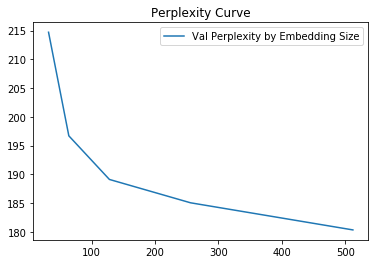

In [ ]:
plt.plot(embedding_size_keys, embedding_size_ppl_list, label='Val Perplexity by Embedding Size')

plt.legend()
plt.title('Perplexity Curve')
plt.show()

### 2.1.2.2 Tune on Learning Rate

In [ ]:
lr_results = {}

In [ ]:
embedding_size = 128
hidden_size = 64
num_layers = 2
rnn_dropout = 0.1
batch_size = 32
optimizer = optim.Adam

In [27]:
for lr in [0.0016, 0.0017]:
    print('Training on lr = {}'.format(lr))
  
    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    # CHANGE THE MODEL HERE
    lstm_model = LSTMLanguageModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

    # CHANGE THE MODEL HERE
    model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=lr)
    
    
    lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel_noTrainLossPrint(lstm_model,
                                                                                                          num_epochs=10,
                                                                                                          load_pretrained=False,
                                                                                                          loaders=wiki_loaders)
    
    # Save the models and losses
    torch.save(lstm_best_model_state_dict, 'lstm_tune_lambda_{}.pth'.format(lr))
    torch.save(lstm_train_losses, 'lstm_tune_lambda_{}_train_losses.pth'.format(lr))
    torch.save(lstm_val_losses, 'lstm_tune_lambda_{}_val_losses.pth'.format(lr))

    lr_results[lr] ={}
    lr_results[lr]['train_losses'] = lstm_train_losses
    lr_results[lr]['val_losses'] = lstm_val_losses
    lr_results[lr]['best_val_loss'] = lstm_best_val_loss
    #lr_results[lr]['best_model_state_dict'] = lstm_best_model_state_dict

Training on lr = 0.0016
Validation loss after 0 epoch = 5.7225
Validation loss after 1 epoch = 5.4520
Validation loss after 2 epoch = 5.3334
Validation loss after 3 epoch = 5.2898
Validation loss after 4 epoch = 5.2735
Validation loss after 5 epoch = 5.2880
Validation loss after 6 epoch = 5.3143
Validation loss after 7 epoch = 5.3293
Validation loss after 8 epoch = 5.3685
Validation loss after 9 epoch = 5.3948
Training on lr = 0.0017
Validation loss after 0 epoch = 5.7112
Validation loss after 1 epoch = 5.4381
Validation loss after 2 epoch = 5.3200
Validation loss after 3 epoch = 5.2757
Validation loss after 4 epoch = 5.2673
Validation loss after 5 epoch = 5.2835
Validation loss after 6 epoch = 5.3017
Validation loss after 7 epoch = 5.3297
Validation loss after 8 epoch = 5.3630
Validation loss after 9 epoch = 5.3900


In [26]:
for lr in [0.00015, 0.0018, 0.0019]:
    print('Training on lr = {}'.format(lr))
  
    options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

    # CHANGE THE MODEL HERE
    lstm_model = LSTMLanguageModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

    # CHANGE THE MODEL HERE
    model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=lr)
    
    
    lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel_noTrainLossPrint(lstm_model,
                                                                                                          num_epochs=10,
                                                                                                          load_pretrained=False,
                                                                                                          loaders=wiki_loaders)
    
    # Save the models and losses
    torch.save(lstm_best_model_state_dict, 'lstm_tune_lambda_{}.pth'.format(lr))
    torch.save(lstm_train_losses, 'lstm_tune_lambda_{}_train_losses.pth'.format(lr))
    torch.save(lstm_val_losses, 'lstm_tune_lambda_{}_val_losses.pth'.format(lr))

    lr_results[lr] ={}
    lr_results[lr]['train_losses'] = lstm_train_losses
    lr_results[lr]['val_losses'] = lstm_val_losses
    lr_results[lr]['best_val_loss'] = lstm_best_val_loss
    #lr_results[lr]['best_model_state_dict'] = lstm_best_model_state_dict

Training on lr = 0.00015
Validation loss after 0 epoch = 6.5820
Validation loss after 1 epoch = 6.3153
Validation loss after 2 epoch = 6.1574
Validation loss after 3 epoch = 6.0288
Validation loss after 4 epoch = 5.9230
Validation loss after 5 epoch = 5.8404
Validation loss after 6 epoch = 5.7709
Validation loss after 7 epoch = 5.7127
Validation loss after 8 epoch = 5.6629
Validation loss after 9 epoch = 5.6226
Training on lr = 0.0018
Validation loss after 0 epoch = 5.7301
Validation loss after 1 epoch = 5.4452
Validation loss after 2 epoch = 5.3269
Validation loss after 3 epoch = 5.2828
Validation loss after 4 epoch = 5.2675
Validation loss after 5 epoch = 5.2941
Validation loss after 6 epoch = 5.3209
Validation loss after 7 epoch = 5.3527
Validation loss after 8 epoch = 5.3913
Validation loss after 9 epoch = 5.4178
Training on lr = 0.0019
Validation loss after 0 epoch = 5.6811
Validation loss after 1 epoch = 5.4276
Validation loss after 2 epoch = 5.3115
Validation loss after 3 epoch 

In [ ]:
lambda_ppl_list = []
lambda_keys = [0.0015, 0.0016, 0.0017, 0.0018, 0.0019]
lr_loss_list = [5.7127, 5.2735, 5.2673, 5.2675, 5.2646]

In [ ]:

for i in range(len(lambda_keys)):
    lr_loss = lr_loss_list[i]
    #print(lr_loss)
    lr_ppl = 2**(lr_loss / np.log(2))
    #print(lr, lr_loss, lr_ppl)
    lambda_ppl_list.append(lr_ppl)
      

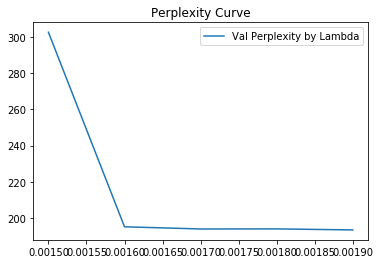

In [32]:
plt.plot(lambda_keys, lambda_ppl_list, label='Val Perplexity by Lambda')

plt.legend()
plt.title('Perplexity Curve')
plt.show()

### 2.1.2.3. The best LSTM Model


In [ ]:
embedding_size = 512 
hidden_size = 128
num_layers = 2
rnn_dropout = 0.1
batch_size = 32
lr = 0.0015
optimizer = optim.Adam

In [37]:
options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size,
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': rnn_dropout,
        }

# CHANGE THE MODEL HERE
lstm_model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# CHANGE THE MODEL HERE
model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=lr)


lstm_train_losses, lstm_val_losses, lstm_best_val_loss, lstm_best_model_state_dict = trainValidModel(lstm_model,
                                                                                                      num_epochs=10,
                                                                                                      load_pretrained=False,
                                                                                                      loaders=wiki_loaders)

Step 0 avg train loss = 10.4161
Step 500 avg train loss = 6.9829
Step 1000 avg train loss = 6.2893
Step 1500 avg train loss = 6.0278
Step 2000 avg train loss = 5.8820
Validation loss after 0 epoch = 5.5718
Step 0 avg train loss = 5.7537
Step 500 avg train loss = 5.5735
Step 1000 avg train loss = 5.5244
Step 1500 avg train loss = 5.4642
Step 2000 avg train loss = 5.4282
Validation loss after 1 epoch = 5.3455
Step 0 avg train loss = 5.1625
Step 500 avg train loss = 5.2078
Step 1000 avg train loss = 5.1957
Step 1500 avg train loss = 5.1831
Step 2000 avg train loss = 5.1623
Validation loss after 2 epoch = 5.2421
Step 0 avg train loss = 4.7632
Step 500 avg train loss = 4.9686
Step 1000 avg train loss = 4.9763
Step 1500 avg train loss = 4.9630
Step 2000 avg train loss = 4.9693
Validation loss after 3 epoch = 5.2071
Step 0 avg train loss = 4.7333
Step 500 avg train loss = 4.7895
Step 1000 avg train loss = 4.8049
Step 1500 avg train loss = 4.8209
Step 2000 avg train loss = 4.8200
Validation lo

In [38]:
torch.save(lstm_best_model_state_dict, 'lstm_best.pth')
print('lstm_train_losses', lstm_train_losses)
torch.save(lstm_train_losses, 'lstm_best_train_losses.pth')
print('lstm_val_losses', lstm_val_losses)
torch.save(lstm_val_losses, 'lstm_best_val_losses.pth')
print('lstm_best_val_losses', lstm_best_val_loss)

lstm_train_losses [6.199911528331287, 5.475005915080181, 5.178893601597208, 4.9700760788755804, 4.810525263383723, 4.684593800091481, 4.579316811021806, 4.4918485144766, 4.415474322653811, 4.347820435536848]
lstm_val_losses [5.5717531528113025, 5.345496613124632, 5.24210718802686, 5.207110962777768, 5.208295482059695, 5.230615819175289, 5.261654884410354, 5.29856259507953, 5.337645692645379, 5.379014299500663]
lstm_best_val_losses 5.207110962777768


#### MD5 Hash Keys for the Baseline, Best, Hyper-parameter tuned models:

- MD5 (rnn_baseline.pth) = 564b41319b531dcce0a8248a66f7bd83
- MD5 (lstm_baseline.pth) = c758795d0532a86aa6e5cb2ecfaa94df
- MD5 (lstm_best.pth) = 292762736c539fb279890faedead686a
- MD5 (lstm_tune_embedding_size_128.pth) = 411bfd2c535ed1c4e51d0ea6346b240a
- MD5 (lstm_tune_embedding_size_256.pth) = adfd9e1fafe98baa35e8d50560d4a6fa
- MD5 (lstm_tune_embedding_size_32.pth) = ef96f3f57f7ac4946c87e2235ce54a8d
- MD5 (lstm_tune_embedding_size_512.pth) = 0a541e200237a6b4dcee305d151b15c8
- MD5 (lstm_tune_embedding_size_64.pth) = f4051b26705d7bacc376dd75660cbb4d
- MD5 (lstm_tune_lambda_0.00015.pth) = 4b5d93e9032161d7b2834a61631582bb
- MD5 (lstm_tune_lambda_0.0015.pth) = f17c43946735c0731fbec606faaeb255
- MD5 (lstm_tune_lambda_0.0016.pth) = cefc31f306114ccbdd227f4e57070549
- MD5 (lstm_tune_lambda_0.0017.pth) = f7f28b533b280756730a26b8968467dc
- MD5 (lstm_tune_lambda_0.0018.pth) = 9d7aeeea48900386d814fa88f369518e
- MD5 (lstm_tune_lambda_0.0019.pth) = a43b8cf4910a1c65052b75eb453d1f0a
- MD5 (lstm_tune_lambda_0.002.pth) = 57ca7f9e7cd77b4bb9c4ddc6483ac32a

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

### 2.2.1. nn.Embedding

#### Closest and Furthest Words

In [ ]:
set_of_word  = ['run', 'dog', 'where', 'quick', 'Oath']
cos_words = {'run': [], 'dog': [], 'where': [], 'quick': [], 'Oath': []}

In [ ]:
embedded_weight = best_lstm.lookup.weight.data
cos = nn.CosineSimilarity(dim=0)

In [ ]:
for i in range(len(wiki_dict)):
    #print(i)
    embedded_word = embedded_weight[i]
    for word in set_of_word:
        embedded_cur_word = embedded_weight[wiki_dict.get_id(word)]
        #print(cos(embedded_word, embedded_cur_word).item())
        cos_words[word].append((i, cos(embedded_word, embedded_cur_word).item()))      

In [ ]:
similarity_words = {}
word_100 = []
word_100_idx = []

for cur_word in set_of_word:
    #print(word)
    sorted_cos = sorted(cos_words[cur_word], key=lambda x: x[1])
    ten_furthest_idx = sorted_cos[:10]
    #print(ten_furthest_idx)
    ten_closest_idx = sorted_cos[:-11:-1]
    #print(ten_closest_idx)
    ten_furthest_words = []
    ten_closest_words = []
    for i in ten_furthest_idx:
        word_100_idx.append(i[0])
        word = wiki_dict.get_token(i[0])
        ten_furthest_words.append(word)
        word_100.append(word)
    for i in ten_closest_idx:
        word_100_idx.append(i[0])
        word = wiki_dict.get_token(i[0])
        ten_closest_words.append(word)
        word_100.append(word)
    similarity_words[cur_word] = (ten_furthest_words, ten_closest_words)
    print("For {}:".format(cur_word))
    print("The 10 furthest words are {}".format(ten_furthest_words))
    print("The 10 closest words are {}".format(ten_closest_words))
    

For run:
The 10 furthest words are ['Lutheran', 'Si', 'Konstanty', 'Inland', 'Wells', 'Franjo', 'antics', 'Tzu', 'Muzaffar', 'airmen']
The 10 closest words are ['run', 'offseason', 'playoff', 'weed', 'flow', 'chasers', 'Blackpool', 'Hulke', 'Night', 'bid']
For dog:
The 10 furthest words are ['latitude', 'Eleven', 'Braves', 'influences', 'Vision', 'muted', 'Bowker', 'flank', 'Magnificent', 'compression']
The 10 closest words are ['dog', 'cleaning', 'pour', 'rowlock', 'agrees', 'Kookaburra', "'il", 'sensuous', 'Fordham', 'humor']
For where:
The 10 furthest words are ['enfilade', 'apartheid', 'Orleans', 'Triana', 'Zonghan', 'devastation', 'darkness', 'banana', 'design', '750']
The 10 closest words are ['where', 'when', 'whereas', 'what', 'calculators', 'whether', 'if', 'Gaming', 'although', 'after']
For quick:
The 10 furthest words are ['cavity', 'totals', 'sprite', 'Megaliths', 'breakup', 'Jifna', 'spored', 'cougar', 'hundreds', 'headland']
The 10 closest words are ['quick', 'H2', 'marit

#### UMAP

In [ ]:
len(word_100)
len(word_100_idx) # e.g. use dictionary.get_id on a list of words

100

In [ ]:
best_lstm.lookup.weight

Parameter containing:
tensor([[ 0.7255, -0.6451, -0.7953,  ..., -1.4722,  1.3819, -1.3225],
        [-2.0331,  0.2291, -1.1025,  ...,  1.1202,  0.3657, -0.2113],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9325, -0.6553, -0.6881,  ...,  0.0892,  0.2816,  0.9744],
        [ 0.9507, -0.5752,  0.2804,  ...,  0.7712,  2.1259, -2.3710],
        [-0.7775, -0.9150,  0.9776,  ...,  0.5025, -1.6645,  0.8108]],
       device='cuda:0', requires_grad=True)

In [ ]:
def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

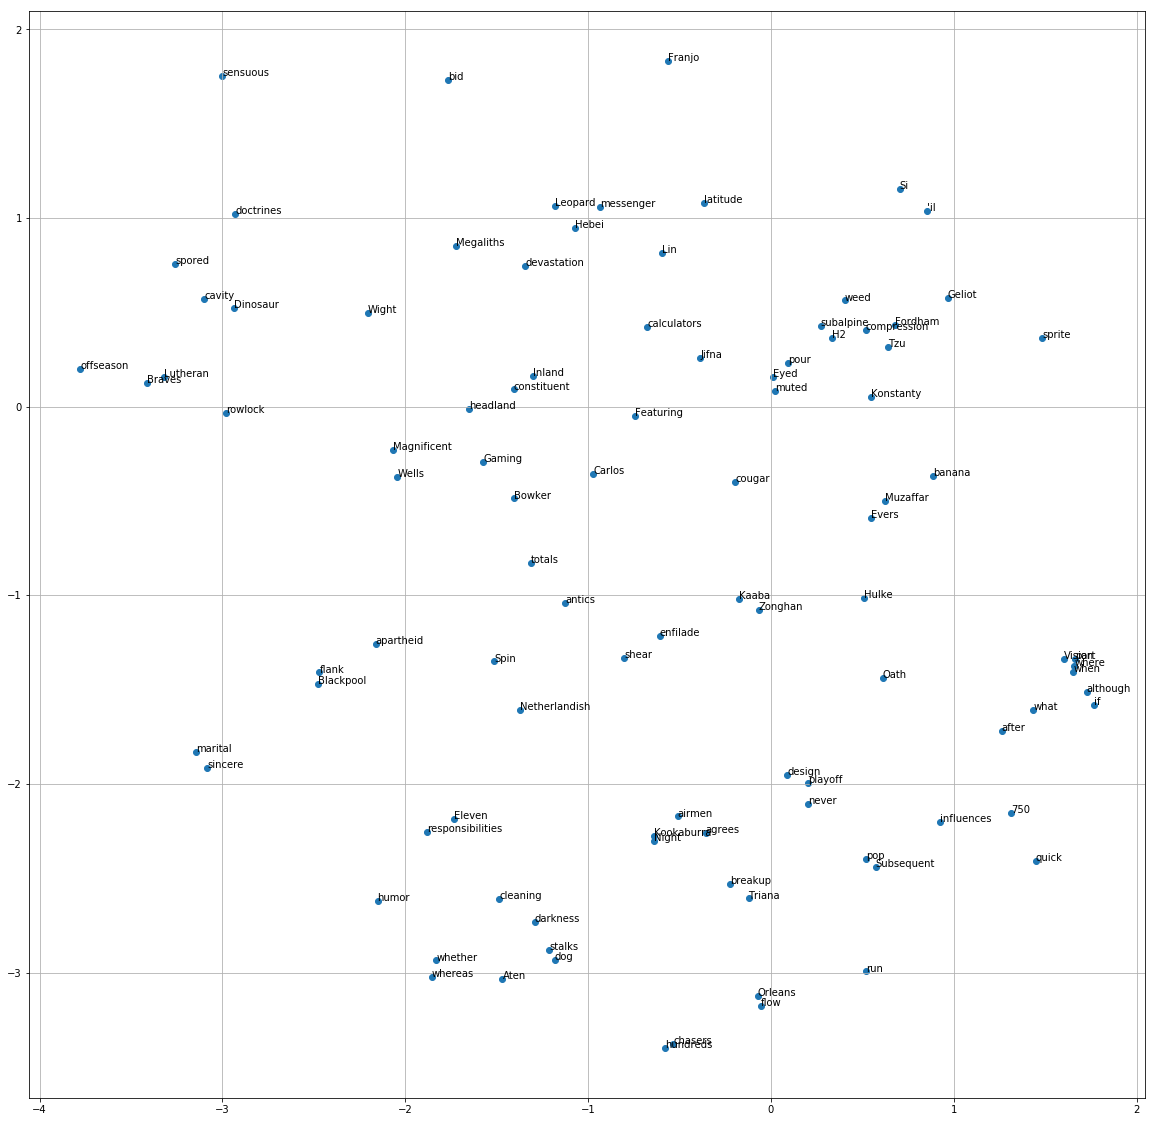

In [ ]:
umap_plot(best_lstm.lookup.weight, word_100_idx, word_100)

### 2.2.1. nn.Projection

#### Closest and Furthest Words

In [24]:
best_lstm

LSTMLanguageModel(
  (lookup): Embedding(33181, 512, padding_idx=2)
  (lstm): LSTM(512, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)

In [ ]:
set_of_word  = ['run', 'dog', 'where', 'quick', 'Oath']
cos_words_projection = {'run': [], 'dog': [], 'where': [], 'quick': [], 'Oath': []}

projection_weight = best_lstm.projection.weight.data
cos = nn.CosineSimilarity(dim=0)

In [ ]:
for i in range(len(wiki_dict)):
    #print(i)
    projection_word = projection_weight[i]
    for word in set_of_word:
        projection_cur_word = projection_weight[wiki_dict.get_id(word)]
        #print(cos(embedded_word, embedded_cur_word).item())
        cos_words_projection[word].append((i, cos(projection_word, projection_cur_word).item()))     

In [27]:
similarity_words_projection = {}
word_100_projection = []
word_100_idx_projection = []

for cur_word in set_of_word:
    #print(word)
    sorted_cos = sorted(cos_words_projection[cur_word], key=lambda x: x[1])
    ten_furthest_idx = sorted_cos[:10]
    #print(ten_furthest_idx)
    ten_closest_idx = sorted_cos[:-11:-1]
    #print(ten_closest_idx)
    ten_furthest_words = []
    ten_closest_words = []
    for i in ten_furthest_idx:
        word_100_idx_projection.append(i[0])
        word = wiki_dict.get_token(i[0])
        ten_furthest_words.append(word)
        word_100_projection.append(word)
    for i in ten_closest_idx:
        word_100_idx_projection.append(i[0])
        word = wiki_dict.get_token(i[0])
        ten_closest_words.append(word)
        word_100_projection.append(word)
    similarity_words_projection[cur_word] = (ten_furthest_words, ten_closest_words)
    print("For {}:".format(cur_word))
    print("The 10 furthest words are {}".format(ten_furthest_words))
    print("The 10 closest words are {}".format(ten_closest_words))

For run:
The 10 furthest words are ['Jaworski', 'Stones', ',', 'More', 'Way', 'Dickson', '@-@', 'Now', 'Light', 'Along']
The 10 closest words are ['run', 'pass', 'drive', 'strike', 'stretch', 'approach', 'move', 'convert', 'take', 'struggle']
For dog:
The 10 furthest words are ['York', 'as', '<eos>', 'England', 'Atlantic', 'it', 'by', 'Ireland', 'for', 'to']
The 10 closest words are ['dog', 'elves', 'vision', 'tea', 'pectoral', 'indulgence', 'Turtles', 'communications', 'henchmen', 'moral']
For where:
The 10 furthest words are ['243', 'war', 'lengthy', '2', 'schooling', 'birth', 'prehistoric', 'AIDS', 'patents', 'prime']
The 10 closest words are ['where', 'abolishing', 'sir', 'revoked', 'which', 'concerning', 'when', 'representing', 'involving', 'Anubis']
For quick:
The 10 furthest words are ['as', ',', 'in', '"', 'and', "'s", '@-@', '<eos>', 'after', 'Young']
The 10 closest words are ['quick', 'inventory', 'mobile', 'unlawful', 'solar', 'thick', 'remnant', 'grandiosity', 'guns', 'soft

In [28]:
len(word_100_projection)

100

#### UMAP

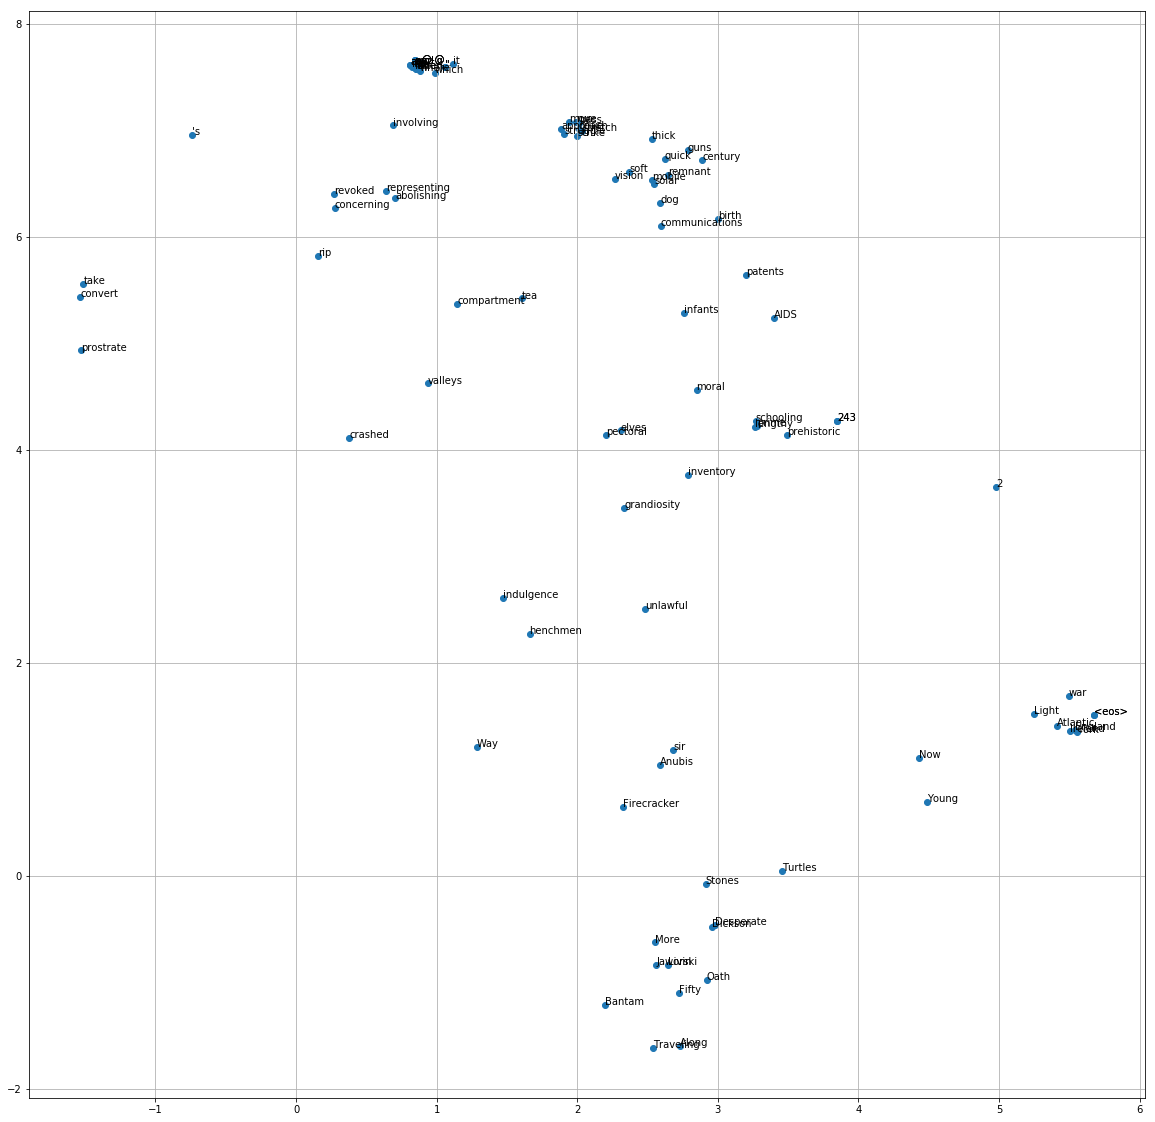

In [29]:
umap_plot(best_lstm.projection.weight, word_100_idx_projection, word_100_projection)

### 2.2.3. Discussion

For the embedding layer, the furthest and closest words are not interpretable (i.e., it is not obvious why those words are furthest or closest to our word of interest). For example, For dog:
The 10 furthest words are ['latitude', 'Eleven', 'Braves', 'influences', 'Vision', 'muted', 'Bowker', 'flank', 'Magnificent', 'compression']
The 10 closest words are ['dog', 'cleaning', 'pour', 'rowlock', 'agrees', 'Kookaburra', "'il", 'sensuous', 'Fordham', 'humor']. We can argue why some words (e.g., cleaning, rowlock) may be closest to dog, but it is not necessarily obvious. We may come to the same conclusion by looking at the UMAP graph. Words that are "close" to each other are not necessarily "close" on the map. In addition, words are more spread out in the graph.

For the projection layer, the furthest and closest words are not interpretable (i.e., it is not obvious why those words are furthest or closest to our word of interest). For dog:
The 10 furthest words are ['York', 'as', '<eos>', 'England', 'Atlantic', 'it', 'by', 'Ireland', 'for', 'to']. The 10 closest words are ['dog', 'elves', 'vision', 'tea', 'pectoral', 'indulgence', 'Turtles', 'communications', 'henchmen', 'moral']. We can argue why some words (e.g., cleaning, rowlock) may be closest to dog, but it is not necessarily obvious. However, in the UMAP, close words are very close with each other. In other words, words are more separatable in the UMAP. It is possibly because after going through the training LSTM layers, the embedding words are customized and trained accordingly to our specific data, allowing the model to group "close" words together.

### II.3 Scoring

In [19]:
## load the best LSTM model
# May need to modify the path
best_lstm = LSTMLanguageModel(options).to(current_device)
best_lstm.load_state_dict(torch.load('lstm_best.pth', map_location = 'cpu'))
best_lstm.eval()

LSTMLanguageModel(
  (lookup): Embedding(33181, 512, padding_idx=2)
  (lstm): LSTM(512, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)

#### 1. Implement a function which returns the log probability (‘score’) of a sequence according to your model.

In [20]:
## seq_out[0] is a 4 * 33181 matrix for sequence '<bos> hello world <eos>'
## dim = 1 since we are looking at the value along the column 
## index is 4*1, and output from torch.gather() should be 4*1 as well

def get_log_prob_score(model, sequence):
    model.eval()
    seq_out = torch.log_softmax(model(torch.tensor([sequence], dtype=torch.long)), dim = 2) 
    return torch.gather(input=seq_out[0, :-1], dim=1, index=torch.tensor([sequence[1:]], dtype=torch.long).reshape(-1, 1)).sum().item()

In [21]:
# test
get_log_prob_score(best_lstm, wiki_dict.encode_token_seq('<bos> hello world <eos>'.split(' ')))

-21.596439361572266

#### 2. Report the 10 sequences from the validation set with the highest scores, and 10 sequences with the lowest scores, according to the best LSTM model that you trained above.

In [22]:
log_prob_scores = []
for sequence in wiki_tokenized_datasets['valid']:
    log_prob_scores.append(get_log_prob_score(best_lstm, sequence))

In [23]:
top10scores, top10idx = torch.topk(torch.tensor(log_prob_scores), 10)

In [24]:
top10scores

tensor([-16.1443, -16.1735, -19.5049, -25.5852, -25.6978, -26.3902, -28.2054,
        -28.4660, -28.7362, -28.9431])

In [25]:
for idx in top10idx:
    decode = wiki_dict.decode_idx_seq(wiki_tokenized_datasets['valid'][idx])
    print(' '.join(decode))

<bos> = = Post @-@ war period = = <eos>
<bos> = = Early life and education = = <eos>
<bos> = = Post @-@ war career = = <eos>
<bos> = = = Scientology sources = = = <eos>
<bos> It originally aired on NBC on April 14 , 2011 . <eos>
<bos> unk> in the second half of the 7th century . <eos>
<bos> = = Return to New Zealand = = <eos>
<bos> = = Later life and death = = <eos>
<bos> It premiered on the Fox network on October 30 , 1998 . <eos>
<bos> = = Culture and the arts = = <eos>


In [26]:
bottom10scores, bottom10idx = torch.topk(torch.tensor(log_prob_scores), 10, largest = False)

In [27]:
for idx in bottom10idx:
    decode = wiki_dict.decode_idx_seq(wiki_tokenized_datasets['valid'][idx])
    print(' '.join(decode))

<bos> To further justify its stance , the German government has also pointed to the long history of U.S. court cases involving Scientology , including the conviction of 11 top Scientologists in 1979 and 1980 for a conspiracy involving the infiltration of U.S. government agencies , <unk> and the theft of government documents , a 1994 U.S. Supreme Court finding that Scientology practices took place in a " <unk> environment " , and Scientology 's track record of pursuing its critics through malicious court cases and private investigators . <eos>
<bos> The letter was conceived and paid for by Hollywood lawyer <unk> Fields , whose clients have included Tom Cruise and John <unk> , and was signed by 34 prominent figures in the U.S. entertainment industry , including the top executives of MGM , Warner Bros. , Paramount , Universal and Sony Pictures Entertainment as well as actors Dustin Hoffman and Goldie <unk> , director Oliver Stone , writers Mario <unk> and <unk> Vidal and talk @-@ show hos

#### 3. Modify one of the high-scoring sequences from above by substituting a few (e.g. 1-3) of its tokens with other tokens from the vocabulary. Find a modiﬁed sequence with a lower score and a modiﬁed sequence with a higher score, and explain why you think the score changed in both cases.

**Original high-scoring sentence: `<bos> It premiered on the Fox network on October 30 , 1998 . <eos>`**

In [28]:
get_log_prob_score(best_lstm, wiki_dict.encode_token_seq('<bos> It premiered on the Fox network on October 30 , 1998 . <eos>'.split(' ')))

-28.73622703552246

**Substitute `premiered` with `remarked`. It is a modified sequence with a lower score.**

In [29]:
wiki_dict.get_id('remarked') #'remarked' is in the vocab

1974

In [30]:
get_log_prob_score(best_lstm, wiki_dict.encode_token_seq('<bos> It remarked on the Fox network on October 30 , 1998 . <eos>'.split(' ')))

-43.751007080078125

**Substitute `the Fox network` with `NBC`. It is a modified sequence with a higher score.**

In [31]:
wiki_dict.get_id('NBC') #'NBC' is in the vocab

8237

In [32]:
get_log_prob_score(best_lstm, wiki_dict.encode_token_seq('<bos> It premiered on NBC on October 30 , 1998 . <eos>'.split(' ')))

-27.69529151916504

**Explanation**: Substituting "premiered" with "remarked" will clearly result in a sequence with a lower score. The following tokens "the Fox network" are more likely to appear after "premiered" rather than "remarked" since "premiered" are in the same context as "the Fox network". Interestingly, substituting "the Fox network" with "NBC" results in a sequence with a slightly higher score. Both "the Fox network" and "NBC" are names of media companies, so the scores for both sequences are very close. In this case, the sequence with "NBC" has a higher score probably because "NBC" only has one token and the modified sequence is shorter.

### II.4 Sampling

#### 1. Implement sampling

In [33]:
#wiki_dict.encode_token_seq('<bos>'.split(' '))

In [34]:
def sample_from_lstm(model):
    model.eval()
    next_hidden = (torch.zeros((2, 1, options['hidden_size'])), torch.zeros((2, 1, options['hidden_size'])))
    sample_sentence = ['<bos>']
    while sample_sentence[-1] != '<eos>':
        embedded_sentence = model.lookup(torch.tensor([wiki_dict.encode_token_seq(sample_sentence)])) #(batch, seq, feature)
        output_probs, next_hidden = model.lstm(embedded_sentence, next_hidden)
        next_idx = torch.multinomial(torch.softmax(model.projection(output_probs)[:, -1, :], dim = 1), 1)
        sample_sentence.append(wiki_dict.get_token(next_idx))
    return sample_sentence

In [35]:
print(' '.join(sample_from_lstm(best_lstm)))

<bos> Backed to support her preference and " interesting success " . <eos>


#### 2. Sample 1,000 sequences from the best LSTM model you trained above.

In [36]:
sample_sequences = []
for sample_num in range(1000):
    sample_sequences.append(sample_from_lstm(best_lstm))

In [37]:
len(sample_sequences)

1000

#### 3. Compare the sampled sequences against 1000 sequences from the validation set in terms of number of unique tokens and sequence length.

In [40]:
len(wiki_tokenized_datasets['valid'])

8464

The validation set has 8,464 sequences. We randomly select 1,000 sequences from the validation set and compare them with the 1,000 sequences sampled from the best LSTM model.

In [41]:
import random
val_sequences = random.sample(wiki_tokenized_datasets['valid'], 1000)
len(val_sequences)

1000

In [42]:
## number of unique tokens

val_unique_tokens = set(token for seq in val_sequences for token in seq)
print('Number of unique tokens in 1,000 sequences from the validation set:', len(val_unique_tokens))

sample_unique_tokens = set(token for seq in sample_sequences for token in seq)
print('Number of unique tokens in 1,000 sequences sampled from the best LSTM model:', len(sample_unique_tokens))

Number of unique tokens in 1,000 sequences from the validation set: 5045
Number of unique tokens in 1,000 sequences sampled from the best LSTM model: 4665


In [43]:
## sequence length

val_lengths = [len(val_seq) for val_seq in val_sequences]
print('The average sequence length for 1,000 sequences from the validation set:', np.mean(val_lengths))

sample_lengths = [len(sample_seq) for sample_seq in sample_sequences]
print('The average sequence length for 1,000 sequences sampled from the best LSTM model:', np.mean(sample_lengths))

The average sequence length for 1,000 sequences from the validation set: 25.23
The average sequence length for 1,000 sequences sampled from the best LSTM model: 17.217


The number of unique tokens in 1,000 sequences from the validation set is larger than the number of unique tokens in 1,000 sequences sampled from the best LSTM model, but the numbers are roughly on the same level. 

On average, a sequence sampled from the validation set is about 8 tokens longer than a sequence sampled from the best LSTM model.

#### 4. Choose 3 sampled sequences and discuss their properties, for instance: Can you tell that these 3 sequences are model-generated rather than human-generated? Do these samples stay on topic? Are they grammatically correct?

In [44]:
[' '.join(seq) for seq in sample_sequences[612:615]]

['<bos> The Real <unk> makes a starting appearance on a title . <eos>',
 '<bos> Florida State had endured it now starting obsolete by <unk> Energy Priorities @-@ free lineman as John Engler . <eos>',
 '<bos> the latter involved at <unk> County , after receiving him with a regular shirt , including Hall . <eos>']

We can tell that these 3 sequences are model-generated since they do not have consistent semantic meanings. They do not stick to the same topic. Some parts of a sampled sequence are grammatically correct, such as "after receiving", but the entire sequence is not grammatically correct.